In [1]:
# 防止tensorflow占满显存
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:

import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import string
from PIL import Image, ImageDraw, ImageFont
# from IPython.display import Image as im
# font = FontProperties(fname='三极正黑体.ttf')
class get_captcha():
    def __init__(self, width, height, length):
        self.width = width
        self.height = height
        self.length = length
    
    def __get_color__(self):
        return (np.random.randint(0, 255) , np.random.randint(0, 255), np.random.randint(0, 255))
    
    def __get_pos__(self, x_start, x_end, y_start, y_end):
        return np.random.randint(x_start, x_end), np.random.randint(y_start, y_end)

    def get_image(self, num, gbk_index):
        img = np.zeros((self.height, self.width, 3), np.uint8)
        img.fill(255)
        # 验证码开始地址
        x_start = 18
        # 汉字验证码位置
        next_pos = 18
        line_num = np.random.randint(3, 9)
        # 画干扰线
        for j in range(line_num):
            cv2.line(img, self.__get_pos__(0, self.width, 0, self.height), self.__get_pos__(0, self.width, 0, self.height), self.__get_color__(), 1, cv2.LINE_8)
        # 画验证码
        for j in range(self.length):
            pos = next_pos
            font_size = 28
            font = '汉仪旗黑-50.ttf'
            y_pos = -10
            # 汉字位置
            if gbk_index == j:
                font_size = 22
                font = '汉仪字典宋.ttf'
                pos = pos - np.random.randint(3, 5)
                y_pos = -6
            next_pos = next_pos + 16
            font = ImageFont.truetype(font, font_size)
            # 这里会报错，'numpy.ndarray' object has no attribute 'load'
            if j == 0:
                img = Image.fromarray(img)
            draw = ImageDraw.Draw(img)
            # 字体窄一些
            draw.text((pos, y_pos), num[j], font=font, fill=self.__get_color__())
            # img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
        # 画1个正方形
        # square_pos = np.random.randint(0, 4)
        # square_size = 17
        # cv2.fillPoly(img, np.array([[[square_pos, square_pos], [square_size, square_pos], [square_size, square_size], [square_pos, square_size]]]), self.__get_color__())
        return np.asarray(img)


In [3]:
# 定义数据生成器
from keras.utils import Sequence
import random

char = string.digits
gbk_char = '会开空宝光玉珠声气流影插翅难飞水阔山高惊天动地落叶归根两小无猜金玉良缘黄道吉日'
class CaptchaSequence(Sequence):
    def __init__(self, char, gbk_char, batch_size, steps, n_len=5, width=118, height=25):
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.characters = char+gbk_char
        self.n_class = len(self.characters)
        self.generator = get_captcha(width=width, height=height, length=n_len)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        gbk_index = np.random.randint(0, 4)
        num = [char[np.random.randint(0, len(char))] if i != gbk_index else gbk_char[np.random.randint(0, len(gbk_char))] for i in range(self.n_len)]
        for i in range(self.batch_size):
            X[i] = np.stack(self.generator.get_image(num, gbk_index)) / 255.0
            for j, ch in enumerate(num):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

Text(0.5, 1.0, '31会72')

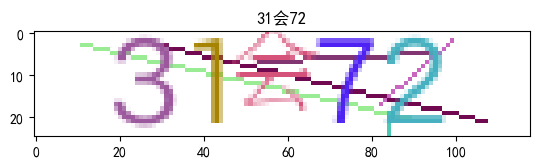

In [4]:
# 测试生成器
characters = char + gbk_char
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])
data = CaptchaSequence(char, gbk_char, batch_size=128, steps=2)
X, y = data[0]
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
plt.title(decode(y))

In [5]:
# 定义loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.compat.v1.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [6]:
# 定义网络结构
from keras.models import *
from keras.layers import *
input_tensor = Input((25, 118, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1), padding='same')(x)

x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)

x = Dense(len(char+gbk_char)+1, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

In [7]:
# 定义模型
labels = Input(name='the_labels', shape=[5], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

In [8]:
from keras.utils import plot_model

plot_model(model, to_file='ctc.png', show_shapes=True)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 118, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 25, 118, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 25, 118, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 118, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 118, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 118, 32)      128       
 hNormalization)                                             

In [9]:
# 准确率回调函数
from tqdm import tqdm
import keras.backend as K
def evaluate(model, batch_size=128, steps=20):
    batch_acc = 0
    valid_data = CaptchaSequence(characters, batch_size, steps)
    for [X_test, y_test, _, _], _ in valid_data:
        y_pred = base_model.predict(X_test)
        shape = y_pred.shape
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

from keras.callbacks import Callback

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = evaluate(base_model)
        logs['val_acc'] = acc
        self.accs.append(acc)
        print(f'\nacc: {acc*100:.4f}')

In [10]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import *

train_data = CaptchaSequence(char, gbk_char, batch_size=520, steps=1000)
valid_data = CaptchaSequence(char, gbk_char, batch_size=520, steps=100)
callbacks = [EarlyStopping(patience=5), Evaluate(), CSVLogger('ctc.csv'), ModelCheckpoint('ctc_best.h5', save_best_only=True)]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit(train_data, epochs=100, validation_data=valid_data, workers=0, use_multiprocessing=True, callbacks=callbacks)

Epoch 1/100


ValueError: in user code:

    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/joey/miniconda3/envs/ml/lib/python3.10/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


In [ ]:
model.load_weights('cnn_best.h5')
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')